# Lista de Exercícios 3: Aproximação de Funções

#### Disciplina: Aprendizado por Reforço
#### Professor: Luiz Chaimowicz
#### Monitores: Marcelo Lemos e Ronaldo Vieira

---

## Instruções

- ***SUBMISSÕES QUE NÃO SEGUIREM AS INSTRUÇÕES A SEGUIR NÃO SERÃO AVALIADAS.***
- Leia atentamente toda a lista de exercícios e familiarize-se com o código fornecido antes de começar a implementação.
- Os locais onde você deverá escrever suas soluções estão demarcados com comentários `# YOUR CODE HERE` ou `YOUR ANSWER HERE`.
- **Não altere o código fora das áreas indicadas, nem adicione ou remova células. O nome deste arquivo também não deve ser modificado.**
- Antes de submeter, certifique-se de que o código esteja funcionando do início ao fim sem erros.
- Submeta apenas este notebook (*ps3.ipynb*) com as suas soluções no Moodle.
- Prazo de entrega: 30/10/2025. Submissões fora do prazo terão uma penalização de -20% da nota final por dia de atraso.
- Utilize a [documentação do Gymnasium](https://gymnasium.farama.org/) para auxiliar sua implementação.
- Em caso de dúvidas entre em contato pelo fórum "Dúvidas com relação aos exercícios e trabalho de curso" no moodle da Disciplina.

---

## Mountain Car

Mountain Car é um ambiente no qual um agente precisa conduzir um carro até o topo de uma montanha. No entanto, o motor do carro não é potente o suficiente para subir diretamente até o topo. Por isso, o agente precisa aprender a aproveitar o impulso - movendo-se para frente e para trás - para ganhar velocidade suficiente e alcançar o topo.

![](https://gymnasium.farama.org/_images/mountain_car.gif)

O espaço de observação é contínuo e composto por dois valores: a posição e a velocidade do carro. O agente pode escolher entre três ações discretas: acelerar o carro para a esquerda, acelerar para a direita, ou não acelerar. A posição inicial do agente é definida de forma uniformemente aleatória no intervalo $[-0.6, -0.4]$. O episódio se encerra quando o carro atinge o topo da montanha à direita (posição $0.5$) ou quando o limite de 200 passos é atingido. A cada passo, o agente recebe uma penalidade de $-1$, incentivando-o a alcançar o objetivo no menor número possível de passos. Para mais detalhes sobre o ambiente leia a [documentação do gymnasium](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Devido à natureza contínua do espaço de estados, métodos tabulares não são eficazes no Mountain Car. Assim, é comum o uso de técnicas de aproximação de função para solucionar o problema de forma eficiente. Nesta lista de exercícios, você irá trabalhar com o ambiente descrito acima. Seu objetivo será implementar o algoritmo *Semi-Gradient Episodic Sarsa* com aproximação linear e explorar como diferentes técnicas de construção de features influenciam o desempenho do agente.

## Semi-Gradient Episodic Sarsa

Nesta atividade, você implementará um agente baseado no algoritmo Semi-Gradient Episodic SARSA, utilizando uma **função de valor linear**.

Antes de iniciar sua implementação, analise a interface `FeatureExtractor` fornecida abaixo. Ela será a base para os construtores de features que você implementará na próxima seção. O agente utilizará um objeto com essa interface para extrair features a partir das observações dos estados.

In [1]:
from abc import ABC, abstractmethod

import numpy as np
import gymnasium as gym
import sklearn
import matplotlib.pyplot as plt

In [2]:
class FeatureExtractor(ABC):
    """
    Interface for feature extractors that convert environment states into feature vectors.
    """

    @property
    @abstractmethod
    def feature_size(self):
        """
        Property that returns the size of the feature vector produced by this extractor.

        Returns:
            An integer representing the length of the feature vector.
        """
        pass

    @abstractmethod
    def extract(self, state):
        """
        Converts a raw state into a 1D feature vector.

        Args:
            state: The observation state from the environment.

        Returns:
            The extracted feature vector representation.
        """
        pass

Siga as instruções abaixo para implementar seu agente:

1. Implemente o método `__init__` que inicializa um novo agente. Ele deve receber como parâmetros o espaço de observações, o espaço de ações, um construtor de features (`feature_extractor`), a taxa de aprendizado $\alpha$, o fator de desconto $\gamma$, e o parâmetro de exploração $\varepsilon$. Inicialize os pesos do modelo na variável `self.weights`.
2. Implemente o método `compute_q_values`, que recebe um vetor de features e calcula os *Q-values* de acordo com a entrada.
3. Implemente o método `choose_action`, responsável por escolher uma ação a partir de um estado observado, seguindo a política $\varepsilon$-greedy.
4. Implemente o método `learn`, que atualiza os pesos do agente com base na experiência obtida durante a interação com o ambiente.
5. Implemente o método `train`, que executa o loop de treinamento do algoritmo Sarsa. O ambiente de treinamento e o número de episódios devem ser fornecidos como parâmetros de entrada. O método deve retornar uma lista com a soma das recompensas obtidas ao longo de cada episódio.

In [3]:
class SGESAgent:
    def __init__(self, observation_space, action_space, feature_extractor, alpha, gamma, epsilon):
        """
        Init Semi-Gradient Episodic Sarsa (SGES) Agent.

        Args:
            observation_space: env's observation space.
            action_space: env's action space.
            feature_extractor (FeatureExtractor): object to convert states to feature vectors.
            alpha (float): step-size param (learning rate).
            gamma (float): discount-rate param.
            epsilon (float): prob for exploration (epsilon-greedy).
        """
        self.action_space = action_space
        self.n_actions = action_space.n
        self.feature_extractor = feature_extractor
        self.feature_size = feature_extractor.feature_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.weights = np.zeros((self.feature_size, self.n_actions))
        self.rng = np.random.default_rng()

    def compute_q_values(self, features):
        """
        Computes the Q-values for all actions given a state's feature vector.
        This implements the linear approximation q(s, a, w) = x(s)^T * w_a for all 'a'.

        Args:
            features (np.ndarray): The feature vector x(s) for the current state.

        Returns:
            np.ndarray: A 1D array of Q-values for all possible actions.
        """
        return features @ self.weights

    def choose_action(self, state):
        """
        Chooses an action from a given state using an epsilon-greedy policy.

        Args:
            state: current env state.

        Returns:
            int: chosen action.
        """
        if self.rng.random() < self.epsilon:
            return self.action_space.sample()
        else:
            features = self.feature_extractor.extract(state)
            q_values = self.compute_q_values(features)
            return np.argmax(q_values)

    def learn(self, state, action, reward, next_state, next_action, done):
        """
        Updates the agent's weights using the semi-gradient Sarsa update rule.

        Args:
            state: state S.
            action: action A.
            reward: reward R.
            next_state: next state S'.
            next_action: next action A'.
            done (bool): true if S' is a terminal state, False otherwise.
        """
        features = self.feature_extractor.extract(state)
        q_value = self.compute_q_values(features)[action]

        if done:
            q_target = reward
        else:
            next_features = self.feature_extractor.extract(next_state)
            next_q_value = self.compute_q_values(next_features)[next_action]
            q_target = reward + self.gamma * next_q_value

        td_error = q_target - q_value
        gradient = features
        self.weights[:, action] += self.alpha * td_error * gradient

    def train(self, env, episodes):
        """
        Runs the main training loop for the SGESAgent.

        Args:
            env: Gymnasium env to train in.
            episodes (int): total num of epis to run.

        Returns:
            list: list containing the total return (sum of rewards) for each episode.
        """
        episode_returns = []

        for _ in range(episodes):
            total_reward = 0
            state, info = env.reset()
            action = self.choose_action(state)
            done = False

            while not done:
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                total_reward += reward
                next_action = self.choose_action(next_state)

                self.learn(state, action, reward, next_state, next_action, done)

                state = next_state
                action = next_action

            episode_returns.append(total_reward)

        return episode_returns

In [4]:
# Não altere ou remova esta célula

In [5]:
# Não altere ou remova esta célula

In [6]:
# Não altere ou remova esta célula

In [7]:
# Não altere ou remova esta célula

## Construção de Features

Com o algoritmo do agente pronto, você deverá implementar 3 modelos de construtores de features diferentes:

1. **Identidade**
2. **Tile Coding**
3. **Funções de Base Radial**

### Identidade

6. Implemente o `IdentityFeatureExtractor`, cujo método `extract` apenas retorna a observação de entrada, sem realizar nenhuma operação nela.

In [8]:
class IdentityFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space):
        """
        Init IdentityFeatureExtractor.

        Args:
            observation_space: env's obs space.
        """
        self._observation_space = observation_space

        self._feature_size = observation_space.shape[0]

    @property
    def feature_size(self):
        """
        Property that returns the size of the feature vector.
        For identity, this is the same as the obs space dimension.

        Returns:
            integer representing the length of the feature vector.
        """
        return self._feature_size

    def extract(self, state):
        """
        Converts a raw state into a 1D feature vector, performs no transformation.

        Args:
            state: obs state from the env.

        Returns:
            untransformed state as the feature vector.
        """
        return state

In [9]:
# Não altere ou remova esta célula

7. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `IdentityFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `identity_agent`.

**Nota:** Não se preocupe se o desempenho do agente com o `IdentityFeatureExtractor` for insatisfatório. Ele será utilizado apenas como baseline, permitindo observar o comportamento do agente quando nenhuma transformação é aplicada às observações do ambiente.

In [10]:
env = gym.make("MountainCar-v0")

ALPHA = 0.01
GAMMA = 0.99
EPSILON = 0.1
EPISODES = 200

identity_feat_extractor = IdentityFeatureExtractor(env.observation_space)

agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=identity_feat_extractor,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON
)

identity_agent = agent.train(env, EPISODES)

env.close()

mean_return = np.mean(identity_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(identity_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -200.00
Mean Return of the Last 20 Episodes: -200.00


In [11]:
# Não altere ou remova esta célula

### Tile Coding

8. Implemente o `TileCodingFeatureExtractor`, cujo método `extract` gera um vetor de features utilizando a técnica de *tile coding*. A quantidade de tilings a ser gerada é definida pelo parâmetro `num_tilings`, enquanto a quantidade de divisões por dimensão em cada tiling é definida pelo parâmetro `tiles_per_dim`. Ambos valores são fornecidos ao construtor da classe. Por exemplo: um `TileCodingFeatureExtractor` com `num_tilings = 3` e `tiles_per_dim = 2` deve gerar 3 tilings, cada um dividindo o espaço em uma grade de tamanho 2$\times$2.

In [12]:
class TileCodingFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, num_tilings, tiles_per_dim):
        """
        Init TileCodingFeatureExtractor.

        creates `num_tilings` grids (tilings),
        each of size `tiles_per_dim` x `tiles_per_dim`.
        The grids are offset from each other to provide a finer-grained
        and generalized feature representation.

        Args:
            observation_space: env's obs space.
            num_tilings (int): num of tilings to create.
            tiles_per_dim (int): num of tiles for each dimension
        """
        self.low = observation_space.low
        self.high = observation_space.high

        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim
        self.num_dims = len(self.low)

        self.tile_widths = (self.high - self.low) / self.tiles_per_dim

        self.tiling_size = self.tiles_per_dim ** self.num_dims

        self._feature_size = self.num_tilings * self.tiling_size

        self.tiling_offsets = np.zeros((self.num_tilings, self.num_dims))
        for i in range(self.num_tilings):
            for j in range(self.num_dims):
                self.tiling_offsets[i, j] = (i * (2 * j + 1) / self.num_tilings) * self.tile_widths[j]

        self.index_multipliers = self.tiles_per_dim ** np.arange(self.num_dims)

    @property
    def feature_size(self):
        """
        Property that returns the total size of the feature vector.

        Returns:
            integer representing the total num of features.
        """
        return self._feature_size

    def extract(self, state):
        """
        Converts a raw state into a sparse 1D binary feature vector.
        The vector will have exactly `num_tilings` active features (1.0),
        one for each tiling.

        Args:
            state: obs state (position, speed).

        Returns:
            extracted binary feature vector.
        """
        features = np.zeros(self._feature_size)

        for i in range(self.num_tilings):
            offset_state = state + self.tiling_offsets[i]

            coordinates = np.floor((offset_state - self.low) / self.tile_widths).astype(int)

            coordinates = np.clip(coordinates, 0, self.tiles_per_dim - 1)

            local_index = np.dot(coordinates, self.index_multipliers)

            global_index = (i * self.tiling_size) + local_index

            features[global_index] = 1.0

        return features

In [13]:
# Não altere ou remova esta célula

9. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `TileCodingFeatureExtractor`. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Para os parâmetros `num_tilings` e `tiles_per_dim`, utilize os valores que proporcionarem os melhores resultados. Armazene os retornos episódicos, obtidos no método `train`, na variável `tile_agent`.

In [21]:
env = gym.make("MountainCar-v0")

ALPHA = 0.01
GAMMA = 0.99
EPSILON = 0.1
EPISODES = 200

NUM_TILINGS = 4
TILES_PER_DIM = 4

tile_feat_extractor = TileCodingFeatureExtractor(
    observation_space=env.observation_space,
    num_tilings=NUM_TILINGS,
    tiles_per_dim=TILES_PER_DIM
)

agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=tile_feat_extractor,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON
)

tile_agent = agent.train(env, EPISODES)

env.close()

mean_return = np.mean(tile_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(tile_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -186.31
Mean Return of the Last 20 Episodes: -187.65


In [15]:
# Não altere ou remova esta célula

### Funções de Base Radial

10. Implemente o `RBFFeatureExtractor`, cujo método `extract` gera um conjunto de features baseadas em *Radial Basis Functions*. A quantidade total de componentes a ser gerada é definida pelo parâmetro `n_components`, fornecido ao construtor da classe. Utilize a biblioteca *scikit-learn* (sklearn) para auxiliar sua implementação.

**Importante:** Você pode combinar RBFs com diferentes parâmetros para capturar melhor dinâmicas complexas do ambiente e potencialmente melhorar o desempenho do agente. Experimente diferentes configurações para identificar as combinações que produzem os melhores resultados de aprendizado. Normalizar o vetor de entrada também pode facilitar o aprendizado.

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

class RBFFeatureExtractor(FeatureExtractor):
    def __init__(self, observation_space, n_components):
        """
        Init RBFFeatureExtractor.

        Args:
            observation_space: env's observation space.
            n_components (int):target num of features.
        """
        samples = np.array(
            [observation_space.sample() for _ in range(10000)],
            dtype=np.float32
        )
        self.scaler = StandardScaler()
        self.scaler.fit(samples)

        self.gammas = [0.1, 0.5, 1.0, 5.0]
        n_gammas = len(self.gammas)

        self.n_components_per_sampler = int(
            np.ceil(n_components / n_gammas)
        )

        self._feature_size = self.n_components_per_sampler * n_gammas

        self.samplers = []
        for gamma in self.gammas:
            sampler = RBFSampler(
                gamma=gamma,
                n_components=self.n_components_per_sampler,
                random_state=42
            )
            sampler.fit(self.scaler.transform(samples))
            self.samplers.append(sampler)

    @property
    def feature_size(self):
        """
        Property that returns the total size of the feature vector.

        Returns:
            An integer representing the total num of features.
        """
        return self._feature_size

    def extract(self, state):
        """
        Converts a raw state into a 1D feature vector using RBFs.

        Args:
            state: obs state (position, speed).

        Returns:
            extracted feature vector.
        """
        state_2d = state.reshape(1, -1)

        scaled_state = self.scaler.transform(state_2d)

        all_features = [
            sampler.transform(scaled_state)[0] for sampler in self.samplers
        ]

        return np.concatenate(all_features)

In [17]:
# Não altere ou remova esta célula

11. Treine um novo agente no ambiente Mountain Car por 200 episódios utilizando o `RBFFeatureExtractor` com 100 componentes. O agente deve ser treinado com os seguintes parâmetros: taxa de aprendizado $\alpha = 0.01$, fator de desconto $\gamma = 0.99$ e parâmetro de exploração $\varepsilon = 0.1$. Armazene os retornos episódicos, obtidos no método `train`, na variável `rbf_agent`.

In [18]:
env = gym.make("MountainCar-v0")

#env = gym.make("MountainCar-v0", render_mode="human")
ALPHA = 0.01
GAMMA = 0.99
EPSILON = 0.1
EPISODES = 200
N_COMPONENTS = 100

rbf_feat_extractor = RBFFeatureExtractor(
    observation_space=env.observation_space,
    n_components=N_COMPONENTS
)

agent = SGESAgent(
    observation_space=env.observation_space,
    action_space=env.action_space,
    feature_extractor=rbf_feat_extractor,
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON
)

rbf_agent = agent.train(env, EPISODES)

env.close()

mean_return = np.mean(rbf_agent)
print(f"Mean Return: {mean_return:.2f}")

last_mean = np.mean(rbf_agent[-20:])
print(f"Mean Return of the Last 20 Episodes: {last_mean:.2f}")

Mean Return: -153.29
Mean Return of the Last 20 Episodes: -134.75


In [19]:
assert 'rbf_agent' in vars()

## Análise

12. Utilize a biblioteca matplotlib para construir um gráfico comparativo dos retornos episódicos obtidos pelos agentes utilizando cada um dos construtores de features implementados. Utilize as variáveis `identiy_agent`, `tile_agent` e `rbf_agent` obtidas nos exercícios anteriores. No eixo X, represente os episódios; no eixo Y, o retorno acumulado por episódio. Caso seja necessário, aplique uma média movel para suavizar as curvas e deixar as tendências mais evidentes. Inclua título, legendas e rótulos de eixos apropriados para facilitar a interpretação. Se utilizar algum tipo de suavização, indique claramente no gráfico qual o método aplicado.

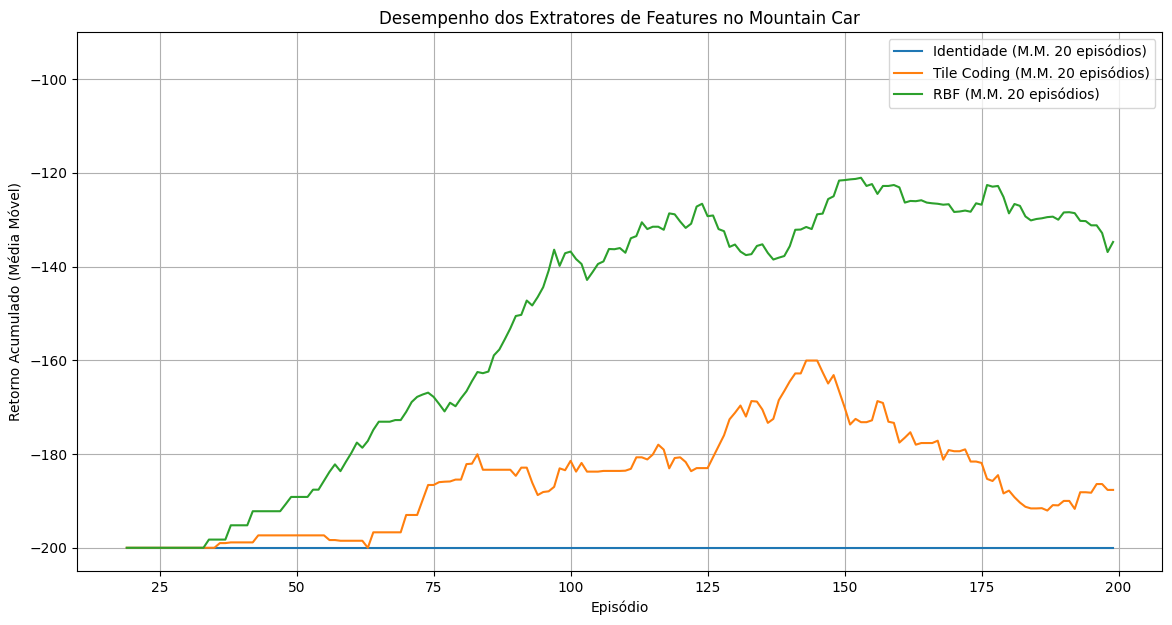

In [22]:
def moving_average(data, window_size):
    """
    Calculates the moving average of a 1D array using conv.
    Args:
        data (np.ndarray or list): The 1D input data.
        window_size (int): The width of the moving avg window.
    Returns:
        np.ndarray: smoothed data.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

WINDOW_SIZE = 20

smooth_identity = moving_average(identity_agent, WINDOW_SIZE)
smooth_tile = moving_average(tile_agent, WINDOW_SIZE)
smooth_rbf = moving_average(rbf_agent, WINDOW_SIZE)

x_axis = np.arange(WINDOW_SIZE - 1, len(identity_agent))

plt.figure(figsize=(14, 7))

plt.plot(x_axis, smooth_identity, label=f'Identidade (M.M. {WINDOW_SIZE} episódios)')
plt.plot(x_axis, smooth_tile, label=f'Tile Coding (M.M. {WINDOW_SIZE} episódios)')
plt.plot(x_axis, smooth_rbf, label=f'RBF (M.M. {WINDOW_SIZE} episódios)')

plt.title('Desempenho dos Extratores de Features no Mountain Car')
plt.xlabel('Episódio')
plt.ylabel('Retorno Acumulado (Média Móvel)')

# Set the y-axis limit to focus on the relevant reward range.
# The worst possible return is -200 (truncation).
plt.ylim([-205, -90])
plt.legend()
plt.grid(True)
plt.show()

13. Explique por que a modelagem do construtor de features pode ser crucial para o desempenho de um agente que utiliza aproximação de função.

O gráfico de desempenho gerado "Desempenho dos Extratores de Features no Mountain Car" ilustra claramente essa questão. A curva azul ('Identidade') permanece estagnada em aproximadamente -200, validando que a falta de uma boa representação impõe um teto de desempenho baixo e impede o aprendizado. Em contraste, as curvas laranja ('Tile Coding') e verde ('RBF') mostram melhoria significativa no retorno ao longo dos episódios, demonstrando que essas features permitem a generalização necessária para que o agente aprenda a resolver a tarefa, superando o teto inicial.

De modo geral, a modelagem do construtor de features é crucial porque, em problemas com aproximação de função, o agente não aprende sobre o estado "bruto" (como `(posição, velocidade)`), mas sim sobre o **vetor de features** que representa esse estado.

Com a aproximação linear que usamos, o Q-value é calculado como um produto escalar: $\hat{q}(s,a,\mathbf{w}) = \mathbf{w}^T \mathbf{x}(s,a)$. Isso significa duas coisas:

1.  **Teto de Desempenho:** a qualidade máxima do agente é limitada pela qualidade das features. Se o vetor $\mathbf{x}(s,a)$ não contiver as informações necessárias para distinguir um estado bom de um estado ruim, o agente **jamais** conseguirá aprender a política ótima, independentemente de quanto ele treine. O construtor `IdentityFeatureExtractor` falha por isso: a função de valor real do Mountain Car é complexa e não-linear (como um "vale" ), e os estados brutos `(posição, velocidade)` não são linearmente separáveis para representá-la;


2.  **Base para Generalização:** em espaços contínuos, o agente nunca visitará o mesmo estado exato duas vezes. O único jeito de ele aprender é **generalizando** o conhecimento de estados visitados para estados novos, mas similares. As features são o mecanismo para isso:

    * Um bom construtor (como Tile Coding ou RBF) garante que estados próximos no espaço original (ex: `(-0.5, 0.0)` e `(-0.51, 0.0)`) produzam vetores de features parecidos (ex: que compartilhem "tiles" ativos).

    * Isso faz com que a atualização de valor para um estado "vaze" para seus vizinhos. O agente aprende uma função de valor "suave" e generalizada, em vez de tentar memorizar pontos discretos, o que seria impossível.


Portanto, o construtor de features é o componente que "traduz" o problema do mundo real para uma forma que o agente linear consegue entender e resolver. Se a tradução for ruim, o agente falha.

14. Quais critérios devem guiar a escolha dos modelos e da quantidade de features a serem utilizadas na construção do espaço de features?

A escolha do modelo e da quantidade de features deve ser guiada por um balanço entre **poder de discriminação** e **capacidade de generalização**.

1.  **Escolha do Modelo (Ex: Tile Coding vs. RBF):**
    * **Natureza do Problema:** o Tile Coding é excelente para partições rígidas do espaço e generalização local (estados vizinhos ativam features parecidos). RBFs oferecem uma generalização mais suave e global. A escolha depende se o valor da função muda abruptamente ou suavemente no espaço de estados;
    * **Dimensionalidade:** o Tile Coding sofre com a "maldição da dimensionalidade" (features crescem exponencialmente com as dimensões do estado). Métodos como RBFs (especialmente suas aproximações) podem escalar melhor para problemas com mais dimensões.

2.  **Quantidade de Features (Ex: `num_tilings` ou `n_components`):**
    * **Poucas Features (Generalização Excessiva):** se houver poucas features (ex: poucos *tiles*), o agente não consegue **discriminar** estados diferentes que exigem ações diferentes. Isso é *underfitting*. O agente pode, por exemplo, agrupar o fundo do vale e a subida da montanha no mesmo "bloco", tornando impossível aprender a política correta;
    * **Muitas Features (Memorização):** se houver features demais (ex: milhares de *tiles*), o agente perde a capacidade de **generalizar**. A experiência de um estado não é "transferida" para seus vizinhos. Isso é *overfitting* (ou memorização). O aprendizado se torna muito lento, pois o agente precisa visitar uma quantidade massiva de estados para aprender os valores de todos os pesos;
    * **O Ponto Ideal:** o objetivo é ter features suficientes para representar as nuances da função de valor (discriminação), mas poucas o suficiente para que o aprendizado de um estado generalize para estados próximos (generalização). Esse balanço é quase sempre encontrado empiricamente, através de ajuste de hiperparâmetros.